In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import combinations

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.diagnostic as dg
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from matplotlib import pyplot as plt

### Estimate regression for SBER

In [278]:
sb_ret = pd.DataFrame(sb_param.groupby(['week#']).aggregate({'Daily_ret': 'sum', 'Returns_rf': 'sum'}))
sb_ret.columns = ["Weekly_ret", "Weekly_ret_rf"]
sb_ret["Premium"] = sb_ret['Weekly_ret'] - sb_ret['Weekly_ret_rf']
sb_ret["week"] = sb_ret.index
sb_proba_loss["week"] = sb_proba_loss.index

In [279]:
sb_final = pd.merge(sb_ret[['week', 'Premium']], sb_proba_loss[['week', 'Ambiguity']], left_on='week', right_on='week', how='left')
sb_final = pd.merge(sb_final, sb_weekly_volat, left_on='week', right_on='week', how='left')
sb_final["Ambiguity_1"] = sb_final["Ambiguity"].shift(1)
sb_final["Ambiguity_2"] = sb_final["Ambiguity"].shift(2)
sb_final["Ambiguity_3"] = sb_final["Ambiguity"].shift(3)
sb_final["Volat_1"] = sb_final["Volat_market"].shift(1)
sb_final["Volat_2"] = sb_final["Volat_market"].shift(2)
sb_final["Volat_3"] = sb_final["Volat_market"].shift(3)
sb_final["Volat"] = sb_final["Volat_market"]
sb_final

,week,Premium,Ambiguity,Volat_market,Ambiguity_1,Ambiguity_2,Ambiguity_3,Volat_1,Volat_2,Volat_3,Volat
0,0,0.034364,0.474749,0.002420,NaN,NaN,NaN,NaN,NaN,NaN,0.002420
1,1,-0.024888,0.287177,0.001875,0.474749,NaN,NaN,0.002420,NaN,NaN,0.001875
2,2,-0.032459,0.248824,0.001119,0.287177,0.474749,NaN,0.001875,0.002420,NaN,0.001119
3,3,-0.038517,0.235398,0.001336,0.248824,0.287177,0.474749,0.001119,0.001875,0.002420,0.001336
4,4,0.050322,0.184318,0.000836,0.235398,0.248824,0.287177,0.001336,0.001119,0.001875,0.000836
...,...,...,...,...,...,...,...,...,...,...,...
117,117,0.020323,0.134452,0.000429,0.221977,0.282591,0.183324,0.000819,0.001139,0.000236,0.000429
118,118,-0.012036,0.274717,0.001700,0.134452,0.221977,0.282591,0.000429,0.000819,0.001139,0.001700
119,119,-0.038183,0.058665,0.003665,0.274717,0.134452,0.221977,0.001700,0.000429,0.000819,0.003665
120,120,0.007786,0.141012,0.000195,0.058665,0.274717,0.134452,0.003665,0.001700,0.000429,0.000195


In [280]:
def get_ols(X):
    '''Function for getting OLS Regression model with intercept'''
    x = sm.add_constant(X)
    model = sm.OLS(y, x).fit()
    return model

In [286]:
# We check regressions with various combinations of suitable parameters (number of parameters from 1 to 3)
# Change p-value from 0.05 to 0.2
factors = ['Ambiguity', 'Ambiguity_1', 'Ambiguity_2', 'Ambiguity_3', 'Volat', 'Volat_1', 'Volat_2', 'Volat_3']
factors2 = list(combinations(factors, 2))
factors2 = [list(x) for x in factors2]
factors3 = list(combinations(factors, 3))
factors3 = [list(x) for x in factors3]
factors4 = list(combinations(factors, 4))
factors4 = [list(x) for x in factors4]
factors_comb = factors4+factors2+factors3

X = sb_final[3:]
y = sb_final.Premium[3:]

f_stats = []
r_sq = []
for factor in factors_comb:
    print(X[factor])
    print(y)
    model = get_ols(X[factor])
    if False in list(model.pvalues < 0.1):
        f_stats.append('bad_ttest')
        r_sq.append('error')
    elif type(factor) != list:
        f_stats.append(model.f_pvalue) #F-test for 1 factor model, equivalent to t-test
        r_sq.append(model.rsquared)
    else:
        vif_stats = [variance_inflation_factor(X[factor].values, i) for i in range(len(factor))]
        mask = pd.Series(vif_stats) < 10
        if False in list(mask):
            f_stats.append('bad_VIF')
            r_sq.append('error')
        else:
            f_stats.append(model.f_pvalue)
            r_sq.append(model.rsquared)

df_ftest = pd.DataFrame(data={'factors': factors_comb, 'f_test': f_stats, 'r_squared': r_sq})
df_ftest = df_ftest[(df_ftest['f_test'] != 'bad_VIF') & (df_ftest['f_test'] != 'bad_ttest')]
df_ftest = df_ftest[df_ftest['f_test'] < 0.2]
# if len(df_ftest) == 0:
#     print('no suitable parameters')
# else:
#     df_ftest = df_ftest.sort_values(by='r_squared', ascending=False)
#     X_best = df_ftest.head(5)['factors']
    
    
    
#     print(df_ftest)
#     print(np.min(df_ftest['f_test']))
#     X_best = df_ftest[df_ftest['f_test'] == np.min(df_ftest['f_test'])]['factors'].values[0] 
#     X_best = df_ftest[df_ftest['r_squared'] == np.max(df_ftest['r_squared'])]['factors'].values[0]

df_ftest


     Ambiguity  Ambiguity_1  Ambiguity_2  Ambiguity_3
3     0.235398     0.248824     0.287177     0.474749
4     0.184318     0.235398     0.248824     0.287177
5     0.275960     0.184318     0.235398     0.248824
6     0.257830     0.275960     0.184318     0.235398
7     0.138341     0.257830     0.275960     0.184318
..         ...          ...          ...          ...
117   0.134452     0.221977     0.282591     0.183324
118   0.274717     0.134452     0.221977     0.282591
119   0.058665     0.274717     0.134452     0.221977
120   0.141012     0.058665     0.274717     0.134452
121   0.428751     0.141012     0.058665     0.274717

[119 rows x 4 columns]
3     -0.038517
4      0.050322
5     -0.023727
6      0.016063
7     -0.002092
         ...   
117    0.020323
118   -0.012036
119   -0.038183
120    0.007786
121    0.051848
Name: Premium, Length: 119, dtype: float64
     Ambiguity  Ambiguity_1  Ambiguity_2     Volat
3     0.235398     0.248824     0.287177  0.001336
4     0

[119 rows x 4 columns]
3     -0.038517
4      0.050322
5     -0.023727
6      0.016063
7     -0.002092
         ...   
117    0.020323
118   -0.012036
119   -0.038183
120    0.007786
121    0.051848
Name: Premium, Length: 119, dtype: float64
     Ambiguity  Ambiguity_2  Ambiguity_3   Volat_2
3     0.235398     0.287177     0.474749  0.001875
4     0.184318     0.248824     0.287177  0.001119
5     0.275960     0.235398     0.248824  0.001336
6     0.257830     0.184318     0.235398  0.000836
7     0.138341     0.275960     0.184318  0.000948
..         ...          ...          ...       ...
117   0.134452     0.282591     0.183324  0.001139
118   0.274717     0.221977     0.282591  0.000819
119   0.058665     0.134452     0.221977  0.000429
120   0.141012     0.274717     0.134452  0.001700
121   0.428751     0.058665     0.274717  0.003665

[119 rows x 4 columns]
3     -0.038517
4      0.050322
5     -0.023727
6      0.016063
7     -0.002092
         ...   
117    0.020323
118   -0.0

[119 rows x 4 columns]
3     -0.038517
4      0.050322
5     -0.023727
6      0.016063
7     -0.002092
         ...   
117    0.020323
118   -0.012036
119   -0.038183
120    0.007786
121    0.051848
Name: Premium, Length: 119, dtype: float64
     Ambiguity     Volat   Volat_2   Volat_3
3     0.235398  0.001336  0.001875  0.002420
4     0.184318  0.000836  0.001119  0.001875
5     0.275960  0.000948  0.001336  0.001119
6     0.257830  0.000893  0.000836  0.001336
7     0.138341  0.000345  0.000948  0.000836
..         ...       ...       ...       ...
117   0.134452  0.000429  0.001139  0.000236
118   0.274717  0.001700  0.000819  0.001139
119   0.058665  0.003665  0.000429  0.000819
120   0.141012  0.000195  0.001700  0.000429
121   0.428751  0.002489  0.003665  0.001700

[119 rows x 4 columns]
3     -0.038517
4      0.050322
5     -0.023727
6      0.016063
7     -0.002092
         ...   
117    0.020323
118   -0.012036
119   -0.038183
120    0.007786
121    0.051848
Name: Premium, Len

[119 rows x 4 columns]
3     -0.038517
4      0.050322
5     -0.023727
6      0.016063
7     -0.002092
         ...   
117    0.020323
118   -0.012036
119   -0.038183
120    0.007786
121    0.051848
Name: Premium, Length: 119, dtype: float64
     Ambiguity_1  Ambiguity_3   Volat_2   Volat_3
3       0.248824     0.474749  0.001875  0.002420
4       0.235398     0.287177  0.001119  0.001875
5       0.184318     0.248824  0.001336  0.001119
6       0.275960     0.235398  0.000836  0.001336
7       0.257830     0.184318  0.000948  0.000836
..           ...          ...       ...       ...
117     0.221977     0.183324  0.001139  0.000236
118     0.134452     0.282591  0.000819  0.001139
119     0.274717     0.221977  0.000429  0.000819
120     0.058665     0.134452  0.001700  0.000429
121     0.141012     0.274717  0.003665  0.001700

[119 rows x 4 columns]
3     -0.038517
4      0.050322
5     -0.023727
6      0.016063
7     -0.002092
         ...   
117    0.020323
118   -0.012036
119   

[119 rows x 4 columns]
3     -0.038517
4      0.050322
5     -0.023727
6      0.016063
7     -0.002092
         ...   
117    0.020323
118   -0.012036
119   -0.038183
120    0.007786
121    0.051848
Name: Premium, Length: 119, dtype: float64
        Volat   Volat_1   Volat_2   Volat_3
3    0.001336  0.001119  0.001875  0.002420
4    0.000836  0.001336  0.001119  0.001875
5    0.000948  0.000836  0.001336  0.001119
6    0.000893  0.000948  0.000836  0.001336
7    0.000345  0.000893  0.000948  0.000836
..        ...       ...       ...       ...
117  0.000429  0.000819  0.001139  0.000236
118  0.001700  0.000429  0.000819  0.001139
119  0.003665  0.001700  0.000429  0.000819
120  0.000195  0.003665  0.001700  0.000429
121  0.002489  0.000195  0.003665  0.001700

[119 rows x 4 columns]
3     -0.038517
4      0.050322
5     -0.023727
6      0.016063
7     -0.002092
         ...   
117    0.020323
118   -0.012036
119   -0.038183
120    0.007786
121    0.051848
Name: Premium, Length: 119, dt

[119 rows x 2 columns]
3     -0.038517
4      0.050322
5     -0.023727
6      0.016063
7     -0.002092
         ...   
117    0.020323
118   -0.012036
119   -0.038183
120    0.007786
121    0.051848
Name: Premium, Length: 119, dtype: float64
     Ambiguity_2     Volat
3       0.287177  0.001336
4       0.248824  0.000836
5       0.235398  0.000948
6       0.184318  0.000893
7       0.275960  0.000345
..           ...       ...
117     0.282591  0.000429
118     0.221977  0.001700
119     0.134452  0.003665
120     0.274717  0.000195
121     0.058665  0.002489

[119 rows x 2 columns]
3     -0.038517
4      0.050322
5     -0.023727
6      0.016063
7     -0.002092
         ...   
117    0.020323
118   -0.012036
119   -0.038183
120    0.007786
121    0.051848
Name: Premium, Length: 119, dtype: float64
     Ambiguity_2   Volat_1
3       0.287177  0.001119
4       0.248824  0.001336
5       0.235398  0.000836
6       0.184318  0.000948
7       0.275960  0.000893
..           ...       ...
11

[119 rows x 3 columns]
3     -0.038517
4      0.050322
5     -0.023727
6      0.016063
7     -0.002092
         ...   
117    0.020323
118   -0.012036
119   -0.038183
120    0.007786
121    0.051848
Name: Premium, Length: 119, dtype: float64
     Ambiguity  Ambiguity_2  Ambiguity_3
3     0.235398     0.287177     0.474749
4     0.184318     0.248824     0.287177
5     0.275960     0.235398     0.248824
6     0.257830     0.184318     0.235398
7     0.138341     0.275960     0.184318
..         ...          ...          ...
117   0.134452     0.282591     0.183324
118   0.274717     0.221977     0.282591
119   0.058665     0.134452     0.221977
120   0.141012     0.274717     0.134452
121   0.428751     0.058665     0.274717

[119 rows x 3 columns]
3     -0.038517
4      0.050322
5     -0.023727
6      0.016063
7     -0.002092
         ...   
117    0.020323
118   -0.012036
119   -0.038183
120    0.007786
121    0.051848
Name: Premium, Length: 119, dtype: float64
     Ambiguity  Ambigui

     Ambiguity_1  Ambiguity_2   Volat_3
3       0.248824     0.287177  0.002420
4       0.235398     0.248824  0.001875
5       0.184318     0.235398  0.001119
6       0.275960     0.184318  0.001336
7       0.257830     0.275960  0.000836
..           ...          ...       ...
117     0.221977     0.282591  0.000236
118     0.134452     0.221977  0.001139
119     0.274717     0.134452  0.000819
120     0.058665     0.274717  0.000429
121     0.141012     0.058665  0.001700

[119 rows x 3 columns]
3     -0.038517
4      0.050322
5     -0.023727
6      0.016063
7     -0.002092
         ...   
117    0.020323
118   -0.012036
119   -0.038183
120    0.007786
121    0.051848
Name: Premium, Length: 119, dtype: float64
     Ambiguity_1  Ambiguity_3     Volat
3       0.248824     0.474749  0.001336
4       0.235398     0.287177  0.000836
5       0.184318     0.248824  0.000948
6       0.275960     0.235398  0.000893
7       0.257830     0.184318  0.000345
..           ...          ...       .

[119 rows x 3 columns]
3     -0.038517
4      0.050322
5     -0.023727
6      0.016063
7     -0.002092
         ...   
117    0.020323
118   -0.012036
119   -0.038183
120    0.007786
121    0.051848
Name: Premium, Length: 119, dtype: float64
     Ambiguity_2   Volat_1   Volat_2
3       0.287177  0.001119  0.001875
4       0.248824  0.001336  0.001119
5       0.235398  0.000836  0.001336
6       0.184318  0.000948  0.000836
7       0.275960  0.000893  0.000948
..           ...       ...       ...
117     0.282591  0.000819  0.001139
118     0.221977  0.000429  0.000819
119     0.134452  0.001700  0.000429
120     0.274717  0.003665  0.001700
121     0.058665  0.000195  0.003665

[119 rows x 3 columns]
3     -0.038517
4      0.050322
5     -0.023727
6      0.016063
7     -0.002092
         ...   
117    0.020323
118   -0.012036
119   -0.038183
120    0.007786
121    0.051848
Name: Premium, Length: 119, dtype: float64
     Ambiguity_2   Volat_1   Volat_3
3       0.287177  0.001119  0.0024

,factors,f_test,r_squared
77,"[Ambiguity_1, Ambiguity_2]",0.00607231,0.0842394
79,"[Ambiguity_1, Volat]",2.68126e-25,0.622992
93,"[Volat, Volat_2]",8.13841e-27,0.645038
129,"[Ambiguity_1, Volat, Volat_2]",1.11685e-26,0.658064


In [287]:
df_ftest_sb = df_ftest.sort_values(by="r_squared", ascending=False)
df_ftest_sb

,factors,f_test,r_squared
129,"[Ambiguity_1, Volat, Volat_2]",1.11685e-26,0.658064
93,"[Volat, Volat_2]",8.13841e-27,0.645038
79,"[Ambiguity_1, Volat]",2.68126e-25,0.622992
77,"[Ambiguity_1, Ambiguity_2]",0.00607231,0.0842394


In [288]:
X_best_sb = list(df_ftest_sb["factors"])
X_best_sb = X_best_sb[0]

In [289]:
X_best_sb

['Ambiguity_1', 'Volat', 'Volat_2']

In [290]:
y = sb_final.Premium[3:]
x = sb_final[X_best_sb][3:]
model_sb_auto = get_ols(x)
model_sb_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Premium   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     73.77
Date:                Fri, 09 Jun 2023   Prob (F-statistic):           1.12e-26
Time:                        21:02:18   Log-Likelihood:                 200.31
No. Observations:                 119   AIC:                            -392.6
Df Residuals:                     115   BIC:                            -381.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0273      0.010      2.670      0.009       0.007       0.047
Ambiguity_1    -0.0723      0.035     -2.093      0.039      -0.141      -0.004
Volat          -2.7442      0.194    -14.120      0.000      -3.129      -2.359
Volat_2         0.6628      0.193      3.434      0.001       0.281       1.045
==============================================================================
Omnibus:                        5.693   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                8.540
Skew:                           0.093   Prob(JB):                       0.0140
Kurtosis:                       4.299   Cond. No.                         49.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Adequacy analysis of the best model

In [53]:
residuals = model_sb_auto.resid
y = sb_final.Premium[3:]
x = sb_final[X_best_sb][3:]

In [54]:
# Normality of residuals
name = ['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis']
test = statsmodels.stats.stattools.jarque_bera(residuals)
dict(zip(name, test))

{'Jarque-Bera': 8.54009874145174,
 'P-value': 0.013981092879594864,
 'Skew': 0.09310990367614903,
 'Kurtosis': 4.299113173964652}

<AxesSubplot:ylabel='Density'>

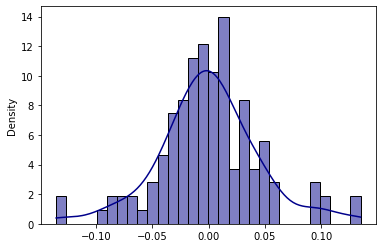

In [55]:
sns.histplot(residuals, color='darkblue', bins=30,
             kde=True, stat="density", linewidth=1)

In [56]:
# Shapiro normality test
stat, p = shapiro(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    
 # Not reject at 1% => almost normal

Statistics=0.972, p=0.013
Sample does not look Gaussian (reject H0)


In [57]:
#Mann-Whitney-Wilkoxon test
resid_set_1 = residuals[:int(len(residuals)/2)]
resid_set_2 = residuals[int(len(residuals)/2):]
stat, p = mannwhitneyu(resid_set_1, resid_set_2)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1594.000, p=0.175


In [58]:
#Goldfeld-Quandt test (heteroscedasticity).
print(statsmodels.stats.diagnostic.het_goldfeldquandt(y, x))


(2.421943891778629, 0.0005510357728664298, 'increasing')


In [59]:
#Durbin-Watson test
stat = durbin_watson(residuals)
if not 1.5<=stat<=2.5:
    print('autocorrelation is problematic')
else:
    print('everything is ok')
print(stat)

everything is ok
1.9839361471917691


In [60]:
# VIF test
vif_data = pd.DataFrame()
vif_data["feature"] = X_best_sb
vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(len(X_best_sb))]
display(vif_data)

,feature,VIF
0,Ambiguity_1,1.097929
1,Volat,1.071372
2,Volat_2,1.041184


### Estimate VTB regressions 

In [311]:
vtb_ret = pd.DataFrame(vtb_param.groupby(['week#']).aggregate({'Daily_ret': 'sum', 'Returns_rf': 'sum'}))
vtb_ret.columns = ["Weekly_ret", "Weekly_ret_rf"]
vtb_ret["Premium"] = vtb_ret['Weekly_ret'] - vtb_ret['Weekly_ret_rf']
vtb_ret["week"] = vtb_ret.index
vtb_proba_loss["week"] = vtb_proba_loss.index

In [312]:
vtb_final = pd.merge(vtb_ret[['week', 'Premium']], vtb_proba_loss[['week', 'Ambiguity']], left_on='week', right_on='week', how='left')
vtb_final = pd.merge(vtb_final, vtb_weekly_volat, left_on='week', right_on='week', how='left')
vtb_final["Ambiguity_1"] = vtb_final["Ambiguity"].shift(1)
vtb_final["Ambiguity_2"] = vtb_final["Ambiguity"].shift(2)
vtb_final["Ambiguity_3"] = vtb_final["Ambiguity"].shift(3)
vtb_final["Volat_1"] = vtb_final["Volat_market"].shift(1)
vtb_final["Volat_2"] = vtb_final["Volat_market"].shift(2)
vtb_final["Volat_3"] = vtb_final["Volat_market"].shift(3)
vtb_final["Volat"] = vtb_final["Volat_market"]

In [313]:
# We check regressions with various combinations of suitable parameters (number of parameters from 1 to 3)
# Change p-value from 0.05 to 0.2
factors = ['Ambiguity', 'Ambiguity_1', 'Ambiguity_2', 'Ambiguity_3', 'Volat', 'Volat_1', 'Volat_2', 'Volat_3']
factors2 = list(combinations(factors, 2))
factors2 = [list(x) for x in factors2]
factors3 = list(combinations(factors, 3))
factors3 = [list(x) for x in factors3]
factors4 = list(combinations(factors, 4))
factors4 = [list(x) for x in factors4]
factors_comb = factors4+factors2+factors3

X = vtb_final[3:]
y = vtb_final.Premium[3:]

f_stats = []
r_sq = []
for factor in factors_comb:
    print(X[factor])
    print(y)
    model = get_ols(X[factor])
    if False in list(model.pvalues < 0.1):
        f_stats.append('bad_ttest')
        r_sq.append('error')
    elif type(factor) != list:
        f_stats.append(model.f_pvalue) #F-test for 1 factor model, equivalent to t-test
        r_sq.append(model.rsquared)
    else:
        vif_stats = [variance_inflation_factor(X[factor].values, i) for i in range(len(factor))]
        mask = pd.Series(vif_stats) < 10
        if False in list(mask):
            f_stats.append('bad_VIF')
            r_sq.append('error')
        else:
            f_stats.append(model.f_pvalue)
            r_sq.append(model.rsquared)

df_ftest = pd.DataFrame(data={'factors': factors_comb, 'f_test': f_stats, 'r_squared': r_sq})
df_ftest = df_ftest[(df_ftest['f_test'] != 'bad_VIF') & (df_ftest['f_test'] != 'bad_ttest')]
df_ftest = df_ftest[df_ftest['f_test'] < 0.2]

df_ftest


     Ambiguity  Ambiguity_1  Ambiguity_2  Ambiguity_3
3     0.194795     0.140632     0.129758     0.325993
4     0.085014     0.194795     0.140632     0.129758
5     0.299104     0.085014     0.194795     0.140632
6     0.282491     0.299104     0.085014     0.194795
7     0.085689     0.282491     0.299104     0.085014
..         ...          ...          ...          ...
117   0.436224     0.124806     0.210252     0.350140
118   0.113133     0.436224     0.124806     0.210252
119   0.429651     0.113133     0.436224     0.124806
120   0.260204     0.429651     0.113133     0.436224
121   0.295792     0.260204     0.429651     0.113133

[119 rows x 4 columns]
3     -0.020504
4      0.033030
5     -0.006333
6     -0.010011
7     -0.006107
         ...   
117    0.094501
118   -0.055533
119    0.030871
120    0.061421
121    0.002466
Name: Premium, Length: 119, dtype: float64
     Ambiguity  Ambiguity_1  Ambiguity_2     Volat
3     0.194795     0.140632     0.129758  0.000527
4     0

Name: Premium, Length: 119, dtype: float64
     Ambiguity  Ambiguity_2  Ambiguity_3   Volat_2
3     0.194795     0.129758     0.325993  0.000829
4     0.085014     0.140632     0.129758  0.000465
5     0.299104     0.194795     0.140632  0.000527
6     0.282491     0.085014     0.194795  0.000192
7     0.085689     0.299104     0.085014  0.000576
..         ...          ...          ...       ...
117   0.436224     0.210252     0.350140  0.001000
118   0.113133     0.124806     0.210252  0.001827
119   0.429651     0.436224     0.124806  0.009405
120   0.260204     0.113133     0.436224  0.001902
121   0.295792     0.429651     0.113133  0.007652

[119 rows x 4 columns]
3     -0.020504
4      0.033030
5     -0.006333
6     -0.010011
7     -0.006107
         ...   
117    0.094501
118   -0.055533
119    0.030871
120    0.061421
121    0.002466
Name: Premium, Length: 119, dtype: float64
     Ambiguity  Ambiguity_2  Ambiguity_3   Volat_3
3     0.194795     0.129758     0.325993  0.000738


Name: Premium, Length: 119, dtype: float64
     Ambiguity_1  Ambiguity_2  Ambiguity_3     Volat
3       0.140632     0.129758     0.325993  0.000527
4       0.194795     0.140632     0.129758  0.000192
5       0.085014     0.194795     0.140632  0.000576
6       0.299104     0.085014     0.194795  0.000629
7       0.282491     0.299104     0.085014  0.000181
..           ...          ...          ...       ...
117     0.124806     0.210252     0.350140  0.009405
118     0.436224     0.124806     0.210252  0.001902
119     0.113133     0.436224     0.124806  0.007652
120     0.429651     0.113133     0.436224  0.002785
121     0.260204     0.429651     0.113133  0.002403

[119 rows x 4 columns]
3     -0.020504
4      0.033030
5     -0.006333
6     -0.010011
7     -0.006107
         ...   
117    0.094501
118   -0.055533
119    0.030871
120    0.061421
121    0.002466
Name: Premium, Length: 119, dtype: float64
     Ambiguity_1  Ambiguity_2  Ambiguity_3   Volat_1
3       0.140632     0.12

[119 rows x 4 columns]
3     -0.020504
4      0.033030
5     -0.006333
6     -0.010011
7     -0.006107
         ...   
117    0.094501
118   -0.055533
119    0.030871
120    0.061421
121    0.002466
Name: Premium, Length: 119, dtype: float64
     Ambiguity_1  Ambiguity_3     Volat   Volat_1
3       0.140632     0.325993  0.000527  0.000465
4       0.194795     0.129758  0.000192  0.000527
5       0.085014     0.140632  0.000576  0.000192
6       0.299104     0.194795  0.000629  0.000576
7       0.282491     0.085014  0.000181  0.000629
..           ...          ...       ...       ...
117     0.124806     0.350140  0.009405  0.001827
118     0.436224     0.210252  0.001902  0.009405
119     0.113133     0.124806  0.007652  0.001902
120     0.429651     0.436224  0.002785  0.007652
121     0.260204     0.113133  0.002403  0.002785

[119 rows x 4 columns]
3     -0.020504
4      0.033030
5     -0.006333
6     -0.010011
7     -0.006107
         ...   
117    0.094501
118   -0.055533
119   

Name: Premium, Length: 119, dtype: float64
     Ambiguity_2     Volat   Volat_1   Volat_3
3       0.129758  0.000527  0.000465  0.000738
4       0.140632  0.000192  0.000527  0.000829
5       0.194795  0.000576  0.000192  0.000465
6       0.085014  0.000629  0.000576  0.000527
7       0.299104  0.000181  0.000629  0.000192
..           ...       ...       ...       ...
117     0.210252  0.009405  0.001827  0.017644
118     0.124806  0.001902  0.009405  0.001000
119     0.436224  0.007652  0.001902  0.001827
120     0.113133  0.002785  0.007652  0.009405
121     0.429651  0.002403  0.002785  0.001902

[119 rows x 4 columns]
3     -0.020504
4      0.033030
5     -0.006333
6     -0.010011
7     -0.006107
         ...   
117    0.094501
118   -0.055533
119    0.030871
120    0.061421
121    0.002466
Name: Premium, Length: 119, dtype: float64
     Ambiguity_2     Volat   Volat_2   Volat_3
3       0.129758  0.000527  0.000829  0.000738
4       0.140632  0.000192  0.000465  0.000829
5       0

     Ambiguity_1   Volat_1
3       0.140632  0.000465
4       0.194795  0.000527
5       0.085014  0.000192
6       0.299104  0.000576
7       0.282491  0.000629
..           ...       ...
117     0.124806  0.001827
118     0.436224  0.009405
119     0.113133  0.001902
120     0.429651  0.007652
121     0.260204  0.002785

[119 rows x 2 columns]
3     -0.020504
4      0.033030
5     -0.006333
6     -0.010011
7     -0.006107
         ...   
117    0.094501
118   -0.055533
119    0.030871
120    0.061421
121    0.002466
Name: Premium, Length: 119, dtype: float64
     Ambiguity_1   Volat_2
3       0.140632  0.000829
4       0.194795  0.000465
5       0.085014  0.000527
6       0.299104  0.000192
7       0.282491  0.000576
..           ...       ...
117     0.124806  0.001000
118     0.436224  0.001827
119     0.113133  0.009405
120     0.429651  0.001902
121     0.260204  0.007652

[119 rows x 2 columns]
3     -0.020504
4      0.033030
5     -0.006333
6     -0.010011
7     -0.006107
     

[119 rows x 3 columns]
3     -0.020504
4      0.033030
5     -0.006333
6     -0.010011
7     -0.006107
         ...   
117    0.094501
118   -0.055533
119    0.030871
120    0.061421
121    0.002466
Name: Premium, Length: 119, dtype: float64
     Ambiguity  Ambiguity_1   Volat_1
3     0.194795     0.140632  0.000465
4     0.085014     0.194795  0.000527
5     0.299104     0.085014  0.000192
6     0.282491     0.299104  0.000576
7     0.085689     0.282491  0.000629
..         ...          ...       ...
117   0.436224     0.124806  0.001827
118   0.113133     0.436224  0.009405
119   0.429651     0.113133  0.001902
120   0.260204     0.429651  0.007652
121   0.295792     0.260204  0.002785

[119 rows x 3 columns]
3     -0.020504
4      0.033030
5     -0.006333
6     -0.010011
7     -0.006107
         ...   
117    0.094501
118   -0.055533
119    0.030871
120    0.061421
121    0.002466
Name: Premium, Length: 119, dtype: float64
     Ambiguity  Ambiguity_1   Volat_2
3     0.194795     0.

     Ambiguity_1  Ambiguity_2   Volat_3
3       0.140632     0.129758  0.000738
4       0.194795     0.140632  0.000829
5       0.085014     0.194795  0.000465
6       0.299104     0.085014  0.000527
7       0.282491     0.299104  0.000192
..           ...          ...       ...
117     0.124806     0.210252  0.017644
118     0.436224     0.124806  0.001000
119     0.113133     0.436224  0.001827
120     0.429651     0.113133  0.009405
121     0.260204     0.429651  0.001902

[119 rows x 3 columns]
3     -0.020504
4      0.033030
5     -0.006333
6     -0.010011
7     -0.006107
         ...   
117    0.094501
118   -0.055533
119    0.030871
120    0.061421
121    0.002466
Name: Premium, Length: 119, dtype: float64
     Ambiguity_1  Ambiguity_3     Volat
3       0.140632     0.325993  0.000527
4       0.194795     0.129758  0.000192
5       0.085014     0.140632  0.000576
6       0.299104     0.194795  0.000629
7       0.282491     0.085014  0.000181
..           ...          ...       .

[119 rows x 3 columns]
3     -0.020504
4      0.033030
5     -0.006333
6     -0.010011
7     -0.006107
         ...   
117    0.094501
118   -0.055533
119    0.030871
120    0.061421
121    0.002466
Name: Premium, Length: 119, dtype: float64
     Ambiguity_2     Volat   Volat_3
3       0.129758  0.000527  0.000738
4       0.140632  0.000192  0.000829
5       0.194795  0.000576  0.000465
6       0.085014  0.000629  0.000527
7       0.299104  0.000181  0.000192
..           ...       ...       ...
117     0.210252  0.009405  0.017644
118     0.124806  0.001902  0.001000
119     0.436224  0.007652  0.001827
120     0.113133  0.002785  0.009405
121     0.429651  0.002403  0.001902

[119 rows x 3 columns]
3     -0.020504
4      0.033030
5     -0.006333
6     -0.010011
7     -0.006107
         ...   
117    0.094501
118   -0.055533
119    0.030871
120    0.061421
121    0.002466
Name: Premium, Length: 119, dtype: float64
     Ambiguity_2   Volat_1   Volat_2
3       0.129758  0.000465  0.0008

,factors,f_test,r_squared
51,"[Ambiguity_1, Volat, Volat_1, Volat_2]",7.32637e-29,0.6993
79,"[Ambiguity_1, Volat]",2.77443e-22,0.575057
80,"[Ambiguity_1, Volat_1]",0.000653887,0.118759
81,"[Ambiguity_1, Volat_2]",0.000211414,0.135748
89,"[Ambiguity_3, Volat_1]",0.0262105,0.0608557
128,"[Ambiguity_1, Volat, Volat_1]",3.81653e-23,0.605811
129,"[Ambiguity_1, Volat, Volat_2]",2.2782e-27,0.667428
131,"[Ambiguity_1, Volat_1, Volat_2]",8.84615e-05,0.168882


In [314]:
df_ftest_vtb = df_ftest.sort_values(by="r_squared", ascending=False)
df_ftest_vtb


,factors,f_test,r_squared
51,"[Ambiguity_1, Volat, Volat_1, Volat_2]",7.32637e-29,0.6993
129,"[Ambiguity_1, Volat, Volat_2]",2.2782e-27,0.667428
128,"[Ambiguity_1, Volat, Volat_1]",3.81653e-23,0.605811
79,"[Ambiguity_1, Volat]",2.77443e-22,0.575057
131,"[Ambiguity_1, Volat_1, Volat_2]",8.84615e-05,0.168882
81,"[Ambiguity_1, Volat_2]",0.000211414,0.135748
80,"[Ambiguity_1, Volat_1]",0.000653887,0.118759
89,"[Ambiguity_3, Volat_1]",0.0262105,0.0608557


In [315]:
X_best_vtb = list(df_ftest["factors"])
X_best_vtb = X_best_vtb[0]

In [316]:
X_best_vtb

['Ambiguity_1', 'Volat', 'Volat_1', 'Volat_2']

In [317]:
y = vtb_final.Premium[3:]
x = vtb_final[X_best_vtb][3:]
model_vtb_auto = get_ols(x)
model_vtb_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Premium   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     66.28
Date:                Fri, 09 Jun 2023   Prob (F-statistic):           7.33e-29
Time:                        21:02:25   Log-Likelihood:                 202.34
No. Observations:                 119   AIC:                            -394.7
Df Residuals:                     114   BIC:                            -380.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0251      0.010      2.566      0.012       0.006       0.044
Ambiguity_1    -0.0875      0.036     -2.434      0.016      -0.159      -0.016
Volat          -1.8864      0.133    -14.181      0.000      -2.150      -1.623
Volat_1        -0.4546      0.131     -3.476      0.001      -0.714      -0.196
Volat_2         0.7961      0.134      5.953      0.000       0.531       1.061
==============================================================================
Omnibus:                        4.837   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                5.408
Skew:                          -0.229   Prob(JB):                       0.0669
Kurtosis:                       3.938   Cond. No.                         35.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Adequacy analysis of the best model

In [68]:
residuals = model_vtb_auto.resid
y = vtb_final.Premium[3:]
x = vtb_final[X_best_vtb][3:]

In [69]:
# Normality of residuals
name = ['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis']
test = statsmodels.stats.stattools.jarque_bera(residuals)
dict(zip(name, test))

{'Jarque-Bera': 5.40808089335706,
 'P-value': 0.06693452028297475,
 'Skew': -0.22912460610416102,
 'Kurtosis': 3.9384631318103756}

<AxesSubplot:ylabel='Density'>

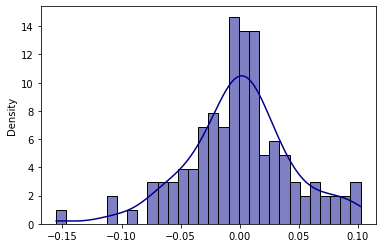

In [70]:
sns.histplot(residuals, color='darkblue', bins=30,
             kde=True, stat="density", linewidth=1)

In [71]:
# Shapiro normality test
stat, p = shapiro(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

    # Not reject at 1% => almost normal

Statistics=0.978, p=0.044
Sample does not look Gaussian (reject H0)


In [72]:
#Mann-Whitney-Wilkoxon test
resid_set_1 = residuals[:int(len(residuals)/2)]
resid_set_2 = residuals[int(len(residuals)/2):]
stat, p = mannwhitneyu(resid_set_1, resid_set_2)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1765.000, p=0.490


In [73]:
#Goldfeld-Quandt test (heteroscedasticity).
print(statsmodels.stats.diagnostic.het_goldfeldquandt(y, x))


(1.674687242830504, 0.028466448357570298, 'increasing')


In [74]:
#Durbin-Watson test
stat = durbin_watson(residuals)
if not 1.5<=stat<=2.5:
    print('autocorrelation is problematic')
else:
    print('everything is ok')
print(stat)

everything is ok
1.887051609553234


In [75]:
# VIF test
vif_data = pd.DataFrame()
vif_data["feature"] = X_best_vtb
vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(len(X_best_vtb))]
display(vif_data)

,feature,VIF
0,Ambiguity_1,1.090052
1,Volat,1.066180
2,Volat_1,1.031563
3,Volat_2,1.019005
